# Import necessary libraries

In [7]:
import sklearn
print(sklearn.__version__)

1.5.1


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

In [2]:
# Load the cleaned dataset
data_path = "C:/Users/Nandan Hegde/OneDrive/Documents/GitHub/MSU_CMSE_830_Final_Semester_project/Movie_analysis_dashboard/Interim_Data/Final_Cleaned_Data.pkl"
data = pd.read_pickle(data_path)


Training XGBoost...
XGBoost Cross-Validation MSE: 0.64

Training Random Forest...
Random Forest Cross-Validation MSE: 0.06

Model Performance (Cross-Validation):
XGBoost: MSE = 0.64
Random Forest: MSE = 0.06

Champion Model: Random Forest

Champion Model Test Performance:
MSE: 0.0066598994121749916
RMSE: 0.08160820676975443
MAE: 0.01674062233835932
R² Score: 0.9993716171854756
Champion model saved to: C:/Users/Nandan Hegde/OneDrive/Documents/GitHub/MSU_CMSE_830_Final_Semester_project/Movie_analysis_dashboard/Models/champion_model.pkl


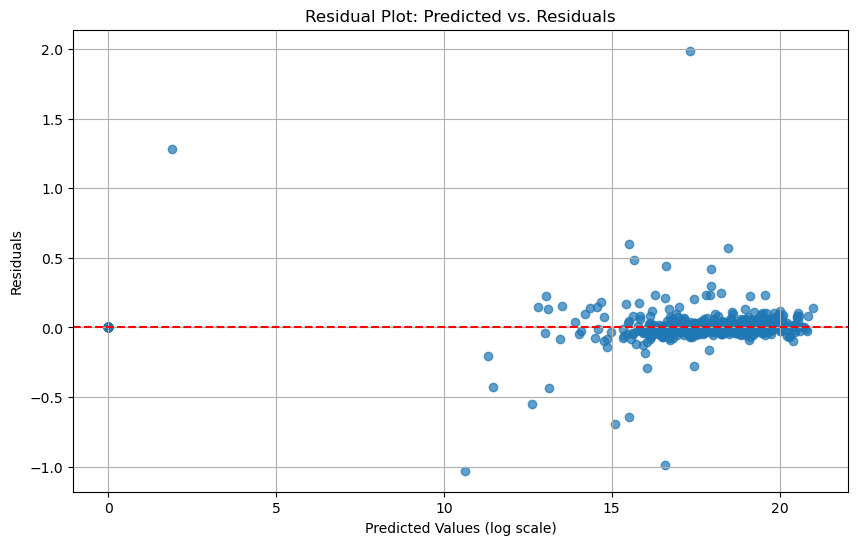

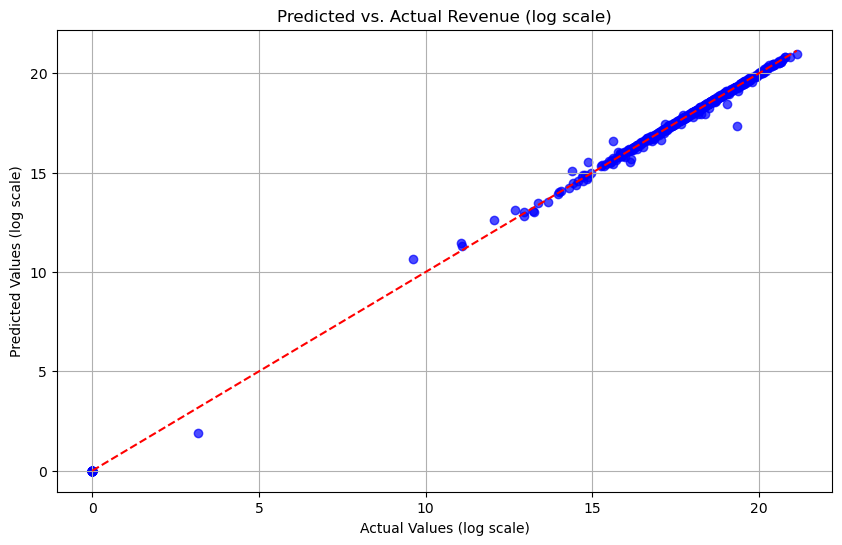

In [3]:
# Feature Engineering: Add profit margin and ROI
data['profit_margin'] = (data['revenue'] - data['budget']) / data['revenue']
data['ROI'] = (data['revenue'] - data['budget']) / data['budget']

# Log transformation to handle skewness
data['log_revenue'] = np.log1p(data['revenue'])
data['log_budget'] = np.log1p(data['budget'])

# Handle missing or invalid values
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_budget', 'log_revenue', 'avg_rating', 'rating_count', 'ROI'])

# Define features and target
features = ['log_budget', 'avg_rating', 'rating_count', 'ROI']
categorical_features = ['genres_x']
target = 'log_revenue'

X = data[features + categorical_features]
y = data[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical and categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define models
models = {
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42)
}

# Evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_mse = -cv_scores.mean()
    results[name] = mean_mse
    print(f"{name} Cross-Validation MSE: {mean_mse:.2f}")

# Display results
print("\nModel Performance (Cross-Validation):")
for name, mse in results.items():
    print(f"{name}: MSE = {mse:.2f}")

# Train the best-performing model (Champion Model)
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f"\nChampion Model: {best_model_name}")

# Fit the champion model on the training data
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
pipeline.fit(X_train, y_train)

# Evaluate on test data
y_pred = pipeline.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nChampion Model Test Performance:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

# Save the champion model
champion_model_path = "C:/Users/Nandan Hegde/OneDrive/Documents/GitHub/MSU_CMSE_830_Final_Semester_project/Movie_analysis_dashboard/Model_outputs/champion_model.pkl"
joblib.dump(pipeline, champion_model_path)
print(f"Champion model saved to: {champion_model_path}")

# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot: Predicted vs. Residuals')
plt.xlabel('Predicted Values (log scale)')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Predicted vs. Actual Revenue (log scale)')
plt.xlabel('Actual Values (log scale)')
plt.ylabel('Predicted Values (log scale)')
plt.grid()
plt.show()